In [1]:
%load_ext autoreload
%autoreload 2
from dataset import AlzheimerDataset
import torch
from torch.utils.data import DataLoader
import matplotlib.pyplot as plt
import numpy as np
from model import AlzheimerClassifierNet
from torch import nn
from tqdm import tqdm
from IPython.display import clear_output


In [2]:
train_dataset = AlzheimerDataset("./dataset/train" )
test_dataset = AlzheimerDataset("./dataset/test")

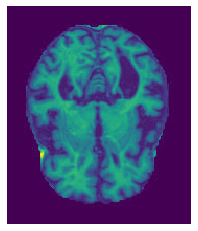

torch.Size([1, 208, 176])


In [3]:
img = (train_dataset[0]["image"].squeeze(0)).numpy()
plt.imshow(img)
plt.axis("off")
plt.show()
print(train_dataset[0]["image"].shape)

In [4]:
model = AlzheimerClassifierNet().to("cuda")
train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True)


In [5]:
def train(dataloader, model, loss_fn, optim):
    model.train()
    run_loss = 0.0
    for i, data in enumerate(dataloader):
        optim.zero_grad()
        image, label = data["image"].cuda(), data["label"].cuda()
        pred = model(image)
        loss = loss_fn(pred, label)
        loss.backward()
        optim.step()
        run_loss += loss.item()
    return run_loss

In [6]:
def overfit_one(image, model, loss_fn, optim):
    model.train()
    optim.zero_grad()
    img, label = image["image"].to("cuda"), image["label"].to("cuda")
    pred = model(img)
    loss = loss_fn(pred, label)
    loss.backward()
    optim.step()
    return loss.item()

In [7]:
optim = torch.optim.Adam(model.parameters(), lr = 1e-3)

In [8]:
loss_fn = nn.CrossEntropyLoss()

In [17]:
single = next(iter(train_loader))

In [10]:
loss = 0.0
for epoch in tqdm(range(100)):
    print(loss)
    loss = train(train_loader, model, loss_fn, optim)
    clear_output()

 13%|██████████▎                                                                    | 13/100 [12:51<1:26:11, 59.45s/it]

25.94249258004129


KeyboardInterrupt: 

In [21]:
lastn = nn.Softmax(1)
model.to("cpu")
lastn(model(next(iter(train_loader))["image"]))

tensor([[1.0000e+00, 5.3191e-13, 1.4707e-06, 9.4660e-10],
        [9.9263e-01, 1.4314e-08, 4.7998e-03, 2.5720e-03],
        [4.8131e-04, 4.7578e-07, 6.4729e-02, 9.3479e-01],
        [1.0651e-02, 1.2258e-04, 7.0921e-01, 2.8002e-01],
        [1.9372e-06, 1.9376e-13, 9.5949e-01, 4.0504e-02],
        [5.2492e-04, 1.6651e-07, 9.9229e-01, 7.1800e-03],
        [1.6002e-09, 7.3936e-18, 9.9999e-01, 1.0964e-05],
        [2.3522e-03, 1.2356e-08, 3.3825e-01, 6.5939e-01],
        [1.8259e-04, 7.1621e-06, 7.9261e-01, 2.0720e-01],
        [6.6714e-06, 2.2670e-08, 9.9579e-01, 4.2077e-03],
        [1.0425e-07, 9.2826e-11, 2.8561e-06, 1.0000e+00],
        [1.0596e-05, 1.8926e-08, 2.8325e-01, 7.1674e-01],
        [4.3976e-02, 1.3940e-08, 4.2697e-04, 9.5560e-01],
        [4.8369e-05, 9.8932e-01, 5.3121e-05, 1.0577e-02],
        [1.2665e-07, 7.2117e-10, 9.9861e-01, 1.3873e-03],
        [9.0063e-03, 2.1358e-06, 9.4941e-01, 4.1582e-02],
        [8.6929e-07, 1.9630e-11, 9.8051e-01, 1.9488e-02],
        [7.688

In [22]:
truth = train_dataset[200]
print(model(torch.reshape(truth["image"], (1, 1, 208, 176)).cuda()))
print(truth["label"])

tensor([[1.0786e-31, 6.4961e-34, 1.0000e+00, 3.7099e-23]], device='cuda:0',
       grad_fn=<SoftmaxBackward>)
0


In [13]:
single["image"]

tensor([[[0., 0., 0.,  ..., 0., 0., 0.],
         [0., 0., 0.,  ..., 0., 0., 0.],
         [0., 0., 0.,  ..., 0., 0., 0.],
         ...,
         [0., 0., 0.,  ..., 0., 0., 0.],
         [0., 0., 0.,  ..., 0., 0., 0.],
         [0., 0., 0.,  ..., 0., 0., 0.]]])